## **Setup**

Importing packages, downloading and normalising the FashionMNIST dataset.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

4423680/4422102 [==============================] - 0s 0us/step


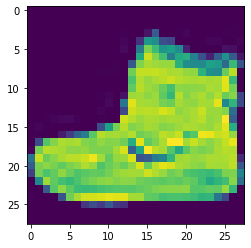

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
plt.imshow(train_images[0])

In [ ]:
train_images = train_images.reshape(train_images.shape[0],28,28, 1)
# normalise the data - shift pixel brightness representation into [-1 ; 1]
train_images = (train_images - 127.5) / 127.5
# check:
# train_images[0]

In [ ]:
BATCH_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(BATCH_SIZE)

## **Creating a Discriminator Model**

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(7, (3, 3), padding="same", input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dense(50, activation="relu"))
  model.add(tf.keras.layers.Dense(1))
  
  return model

In [ ]:
discriminator = make_discriminator_model()

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.23901644]], dtype=float32)>

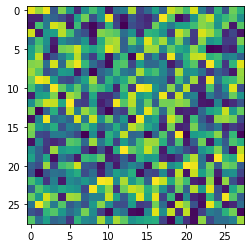

In [ ]:
noise = np.random.rand(1,28,28,1).astype("float32")
plt.imshow(noise[0].reshape(28,28))
discriminator(noise)

In [ ]:
discriminator_optimizer = tf.optimizers.Adam(1e-3)

In [ ]:
def get_discriminator_loss(real_pred, fake_pred):
  real_pred = tf.sigmoid(real_pred)
  fake_pred = tf.sigmoid(fake_pred)
  # BCE between 1 values and each prediction about real images
  real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_pred), real_pred)
  # BCE between 0 values and each pred. about fake images
  fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_pred), fake_pred)
  return real_loss + fake_loss

## **Creating a Generator**

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256, input_shape = (100, )))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Reshape((7,7,256)))
  model.add(tf.keras.layers.Conv2DTranspose(128,(3,3), padding="same"))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(64,(3,3), strides=(2,2), padding="same"))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(1,(3,3), strides=(2,2), padding="same"))
  
  return model

In [ ]:
generator = make_generator_model()

In [ ]:
generator_optimizer = tf.optimizers.Adam(1e-4)

In [ ]:
def get_generator_loss(fake_pred):
  fake_pred = tf.sigmoid(fake_pred)
  # BCE between 1 values and each pred. about fake images
  # (Since the generator wants to fool the discriminator)
  fake_loss = tf.losses.binary_crossentropy(tf.ones_like(fake_pred), fake_pred)
  return fake_loss

## **Training**
  

In [ ]:
def train(dataset, epochs):
  for _ in range(epochs):
    for images in dataset:
      images = tf.cast(images, tf.dtypes.float32)
      train_step(images)

In [ ]:
def train_step(images):
  fake_image_noise = np.random.randn(BATCH_SIZE, 100).astype("float32")
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(fake_image_noise)
    real_output = discriminator(images)
    fake_output = discriminator(generated_images)

    gen_loss = get_generator_loss(fake_output)
    disc_loss = get_discriminator_loss(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    print("generator loss:     ", np.mean(gen_loss))
    print("discriminator loss: ", np.mean(disc_loss))

In [ ]:
train(train_dataset, 10)

Streaming output truncated to the last 5000 lines.
discriminator loss:  0.044969477
generator loss:      8.156314
discriminator loss:  0.0066241855
generator loss:      8.71557
discriminator loss:  0.05782555
generator loss:      7.8230653
discriminator loss:  0.107774265
generator loss:      5.9191327
discriminator loss:  0.0119086895
generator loss:      4.17359
discriminator loss:  0.04362382
generator loss:      4.6342516
discriminator loss:  0.07492608
generator loss:      6.130421
discriminator loss:  0.09199086
generator loss:      7.038969
discriminator loss:  0.07382597
generator loss:      7.5447145
discriminator loss:  0.16622551
generator loss:      6.8142204
discriminator loss:  0.014910531
generator loss:      6.8305926
discriminator loss:  0.007784524
generator loss:      6.4341164
discriminator loss:  0.03269066
generator loss:      5.832308
discriminator loss:  0.027175963
generator loss:      5.932515
discriminator loss:  0.07747436
generator loss:      6.3819165
disc

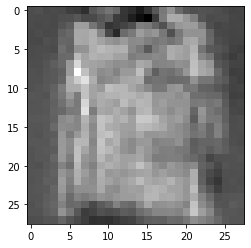

In [ ]:
plt.imshow(tf.reshape(generator(np.random.randn(1,100)), (28,28)), cmap="gray")